In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
import random
from time import time

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

import data_handler as dh
import semeval_data_helper as sdh


# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
# plt.rcParams['figure.figsize'] = (16,9)

import mpld3

In [2]:
# reload(sdh)

In [3]:
# reload(nn)
import relembed_clustered as nn

In [4]:
# reload(eh)
import experiment_helper as eh

In [5]:
shuffle_seed = 20

In [6]:
# reload(dh)
DH = dh.DataHandler('data/semeval_wiki_sdp_include_100000', valid_percent=1, shuffle_seed=shuffle_seed) # for semeval

Creating Data objects...
Done creating Data objects
792234 total examples :: 784311 training : 7923 valid (99:1 split)
Vocab size: 32468 Dep size: 50 POS size: 18


In [7]:
# reload(sdh)
train, valid, test, label2int, int2label = sdh.load_semeval_data(include_ends=True, shuffle_seed=shuffle_seed)
num_classes = len(int2label.keys())

Didn't find common ancestor
1790	"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."

(The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport )
Bad sentence: '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
((The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport ), None)
Skipping this one... '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
(None, None, None, 4)
Num training: 7199
Num valididation: 800
Didn't find common ancestor
8310	"Tributes have been paid to the <e1>writer</e1> who created Goodness Gracious Me, the hit BBC television <e2>series</e2>."

(Tributes have been paid to the writer 

In [8]:
# convert the semeval data to indices under the wiki vocab:
train['sdps'] = DH.sentences_to_sequences(train['sdps'])
valid['sdps'] = DH.sentences_to_sequences(valid['sdps'])
test['sdps'] = DH.sentences_to_sequences(test['sdps'])
    
train['targets'] = DH.sentences_to_sequences(train['targets'])
valid['targets'] = DH.sentences_to_sequences(valid['targets'])
test['targets'] = DH.sentences_to_sequences(test['targets'])

In [9]:
print(train['targets'][1], train['sdps'][1]) # small sample

[451, 28773] [[451, 6, 0], [29, 7, 2], [370, 9, 0], [28773, 4, 0]]


In [10]:
max_seq_len = max([len(path) for path in train['sdps']+valid['sdps']+test['sdps']])
print(max_seq_len, DH.max_seq_len)
DH.max_seq_len = max_seq_len

13 9


In [11]:
# the embedding matrix is started of as random uniform [-1,1]
# then we replace everything but the OOV tokens with the approprate google vector
fname = 'data/GoogleNews-vectors-negative300.bin'
word2vec = Word2Vec.load_word2vec_format(fname, binary=True)

word_embeddings = np.random.uniform(low=-1., high=1., size=[DH.vocab_size, 300]).astype(np.float32)
num_found = 0
for i, token in enumerate(DH.vocab):
    if token in word2vec:
        word_embeddings[i] = word2vec[token] #/= np.sqrt(np.sum(word2vec[token]**2))#, 1, keepdims=True))
        num_found += 1
print("%i / %i pretrained" % (num_found, DH.vocab_size))
del word2vec # save a lot of RAM
# normalize them
# word_embeddings /= np.sqrt(np.sum(word_embeddings**2, 1, keepdims=True))

26280 / 32468 pretrained


In [12]:
def reset_drnn(model_name='relcluster', bi=True, dep_embed_size=25, pos_embed_size=25, hidden_size=300,
               word_embed_size=None, max_grad_norm=3., max_to_keep=10, num_clusters=50,
               supervised=True, interactive=True):
    if word_embed_size:    
        config = {
            'max_num_steps':DH.max_seq_len,
            'word_embed_size':word_embed_size,
            'dep_embed_size':dep_embed_size,
            'pos_embed_size':pos_embed_size,
            'num_clusters':num_clusters,
            'bidirectional':bi,
            'hidden_size':hidden_size,
            'supervised':supervised,
            'interactive':interactive,
            'hidden_layer_size':1000,
            'vocab_size':DH.vocab_size,
            'dep_vocab_size':DH.dep_size,
            'pos_vocab_size':DH.pos_size,
            'num_predict_classes':num_classes,
            'pretrained_word_embeddings':None,
            'max_grad_norm':3.,
            'model_name':model_name,
            'max_to_keep':max_to_keep,
            'checkpoint_prefix':'checkpoints/',
            'summary_prefix':'tensor_summaries/'
        }
    else: # use pretrained google vectors
        config = {
            'max_num_steps':DH.max_seq_len,
            'word_embed_size':300,
            'dep_embed_size':dep_embed_size,
            'pos_embed_size':pos_embed_size,
            'num_clusters':num_clusters,
            'bidirectional':bi,
            'hidden_size':hidden_size,
            'supervised':supervised,
            'interactive':interactive,
            'hidden_layer_size':1000,
            'vocab_size':DH.vocab_size,
            'dep_vocab_size':DH.dep_size,
            'pos_vocab_size':DH.pos_size,
            'num_predict_classes':num_classes,
            'pretrained_word_embeddings':word_embeddings,
            'max_grad_norm':3.,
            'model_name':model_name,            
            'max_to_keep':max_to_keep,
            'checkpoint_prefix':'checkpoints/',
            'summary_prefix':'tensor_summaries/'
        }
    try:
        tf.reset_default_graph()
    except:
        pass
    try:
        tf.get_default_session().close()
    except:
        pass
    drnn = nn.RelEmbed(config)
    print(drnn)
    return drnn
# drnn = reset_drnn()

In [13]:
def cluster_labels(targets, labels, DH, brown_clusters, num_clusters):
    """Convert labels to integer based on pair of brown clusters"""
    for i, target in enumerate(targets):
        x,y = target
        x = DH.vocab_at(x)
        y = DH.vocab_at(y)
        try:
            cx = brown_clusters[x]
        except KeyError:
            cx = '<OOV>'
        try:
            cy = brown_clusters[y]
        except KeyError:
            cy = '<OOV>'
        labels[i] = cluster2int[cx]*num_clusters + cluster2int[cy]
    return labels

In [14]:
def run_validation_test(num_nearby=20):
    valid_phrases, valid_targets , _, valid_lens = DH.validation_batch()
    random_index = int(random.uniform(0, len(valid_lens)))
    query_phrase = valid_phrases[random_index]
    query_len = valid_lens[random_index]
    query_target = valid_targets[random_index].reshape((1,2))
    padded_qp = np.zeros([DH.max_seq_len, 3]).astype(np.int32)
    padded_qp[:len(query_phrase), 0] = [x[0] for x in query_phrase]
    padded_qp[:len(query_phrase), 1] = [x[1] for x in query_phrase]
    padded_qp[:len(query_phrase), 2] = [x[2] for x in query_phrase]
    dists, phrase_idx = drnn.validation_phrase_nearby(padded_qp, query_len, query_target,
                                                      valid_phrases, valid_lens, valid_targets)
    print("="*80)
    print("Top %i closest phrases to <%s> '%s' <%s>" 
          % (num_nearby, DH.vocab_at(query_target[0,0]), 
             DH.sequence_to_sentence(query_phrase, query_len), 
             DH.vocab_at(query_target[0,1])))
    for i in range(num_nearby):
        dist = dists[i]
        phrase = valid_phrases[phrase_idx[i]]
        len_ = valid_lens[phrase_idx[i]]
        target = valid_targets[phrase_idx[i]]
        print("%i: %0.3f : <%s> '%s' <%s>" 
              % (i, dist, DH.vocab_at(target[0]),
                 DH.sequence_to_sentence(phrase, len_),
                 DH.vocab_at(target[1])))
    print("="*80)
#     drnn.save_validation_accuracy(frac_correct)

In [15]:
def time_left(num_epochs, num_steps, fit_time, nearby_time, start_time, nearby_mod):
    total = num_epochs*num_steps*fit_time + ((num_epochs*num_steps)/float(nearby_mod))*nearby_time
    return total - (time() - start_time)

In [16]:
# reload(dh)
# DH = dh.DataHandler('data/semeval_wiki_sdp_10000', valid_percent=10, shuffle_seed=shuffle_seed) # for semeval

In [17]:
brown_clusters = {}
lines = open('data/shuffled.en.tok-c100-p1.out/paths', 'r').readlines()
for line in lines:
    vec = line.split()
    brown_clusters[vec[1]] = vec[0]
del lines



In [18]:
cluster2int = {c:i for i,c in enumerate(set(brown_clusters.values()))} 
# add in an OOV cluster
# TODO: Remove this and append semeval data to wiki data bbefore brown clustering
cluster2int['<OOV>'] = 100
print(cluster2int)
num_clusters=len(cluster2int.keys())
print('%i clusters' % num_clusters)

{'11001010': 0, '100100': 1, '100101': 81, '10100': 3, '0011111111': 4, '0011111110': 5, '10011111': 6, '10011110': 7, '11001100111': 8, '11001100110': 9, '1101110': 10, '1101111000': 11, '11001001': 13, '11001000': 14, '11011110010': 15, '01111011': 16, '01111010': 17, '001010': 18, '0111100': 19, '1111010': 20, '1101111010': 21, '01011': 22, '01010': 23, '001111110': 24, '1100110110': 25, '1100110111': 26, '1011101': 27, '1011100': 28, '1100111110': 29, '0111110': 30, '0111111': 31, '110011110': 32, '110001101': 33, '110001100': 12, '101011': 35, '101010': 36, '110011000': 37, '0011110': 38, '1011110': 39, '1011111': 40, '0100': 41, '110010110': 42, '110010111': 43, '1100000': 34, '11110110': 45, '1001110': 84, '00100': 44, '1000': 47, '0011100': 48, '0011101': 49, '11001110': 50, '11000101': 51, '11000100': 52, '001100': 53, '001101': 54, '11011111101': 55, '11011111100': 56, '11011110110': 57, '01101': 58, '01100': 59, '1001100': 60, '1001101': 61, '11010100': 62, '11010101': 63, '

In [142]:
# reload(nn)
# drnn = reset_drnn(model_name='wikicluster_state', bi=False, word_embed_size=None, num_clusters=num_clusters)

# hyperparameters
num_epochs = 3
batch_size =250
target_neg=True
neg_per = 0
neg_level = 1
num_nearby = 25
nearby_mod = 50
sample_power = .75
DH.scale_vocab_dist(sample_power)

# bookkeeping
num_steps = DH.num_steps(batch_size)
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()

#timing stuff
start = time()
fit_time = 0
nearby_time = 0

best_valid = 100000
best_model = None

for epoch in range(num_epochs):
    DH.shuffle_data()
    for step , batch in enumerate(DH.batches(batch_size, target_neg=target_neg, 
                                             neg_per=neg_per, neg_level=neg_level)):
        # turn batch labels into clusters
        labels = cluster_labels(batch[1], batch[2], DH, brown_clusters, num_clusters)
#             c1 = brown_clusters
        t0 = time()
        loss = drnn.partial_unsup_fit(batch[0], batch[1], labels, batch[3])
        fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
        if step % 10 == 0:
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
#             left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
#             ml,sl = divmod(left, 60)
#             hl,ml = divmod(ml, 60)
            pps = batch_size*(neg_per + 1) / fit_time 
            print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec" 
                  % (h,m,s, step, num_steps, epoch, loss, pps))
        if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
            t0 = time()
            run_validation_test(num_nearby) # check out the nearby phrases in the validation set
            valid_batch = DH.validation_batch()
            valid_labels = cluster_labels(valid_batch[1], valid_batch[2], DH, brown_clusters, num_clusters)
            valid_loss = drnn.validation_loss(valid_batch[0], valid_batch[1], valid_labels, valid_batch[3])
            print("Validation loss: %0.4f" % valid_loss)
            nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average
#             if valid_loss <= best_valid:
#                 best_valid = valid_loss
#                 best_model = drnn.checkpoint()
        if (time() - save_time) > save_interval:
            print("Saving model...")
            drnn.checkpoint()
            save_time = time()
        total_step +=1
drnn.checkpoint()
print("Best model was %s" % best_model)

<DPNN: W:300, D:25, P:25 H:300, V:23108>
(0:0:1) step 0/274, epoch 0 Training Loss = 14.33154 :: 393.771 phrases/sec
Top 25 closest phrases to <martin> 'martin switched like hardy' <hardy>
0: 1.000 : <martin> 'martin switched like hardy' <hardy>
1: 0.480 : <navy> 'navy turned see adapted they' <they>
2: 0.465 : <saints> 'saints to traded for running morton' <morton>
3: 0.462 : <twins> 'twins to dealt along with martin' <martin>
4: 0.459 : <antonio> 'antonio from businessmen by supported developed connect antonio' <antonio>
5: 0.458 : <crops> 'crops growing for used is pastures' <pastures>
6: 0.451 : <victoria> 'victoria to migrated served during i' <i>
7: 0.443 : <election> 'election in returned by defeating martin' <martin>
8: 0.438 : <version> 'version invented by bird' <bird>
9: 0.437 : <time> 'time around filled placed on os' <os>
10: 0.436 : <agents> 'agents say picked distributor fired by paul' <paul>
11: 0.434 : <england> 'england for sailed received training at plain' <plain>
1

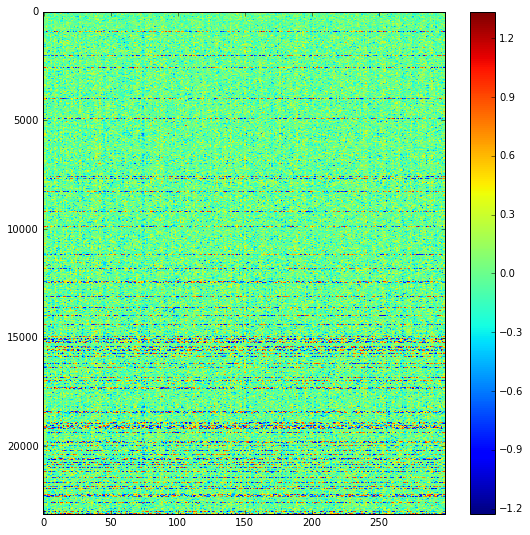

In [143]:
fig, ax = plt.subplots(1,1, figsize=(9,9))
im = ax.imshow(word_embeddings, aspect='auto', interpolation='nearest')
plt.colorbar(im)

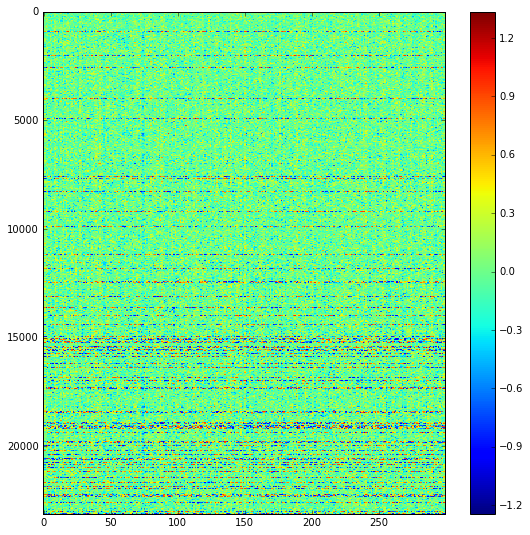

In [196]:
words = drnn._word_embeddings.eval()
fig, ax = plt.subplots(1,1, figsize=(9,9))
im = ax.imshow(words, aspect='auto', interpolation='nearest')
plt.colorbar(im)

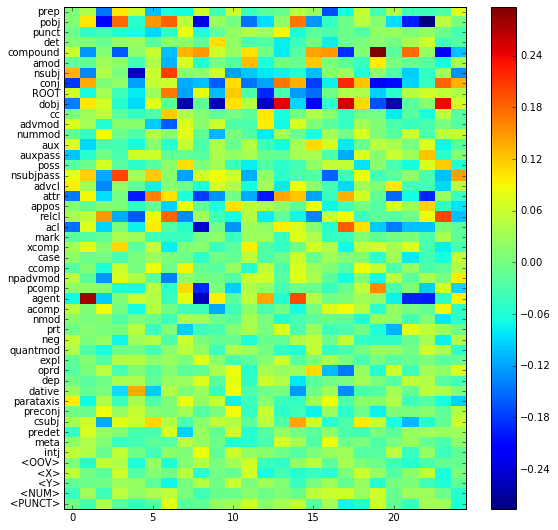

In [195]:
embeds = drnn._dependency_embeddings.eval()
fig, ax = plt.subplots(1,1, figsize=(9,9))
im = ax.imshow(embeds, aspect='auto', interpolation='nearest')
plt.colorbar(im)
ax.set_yticklabels(DH._dep_vocab)
ax.set_yticks(range(len(DH._dep_vocab)))

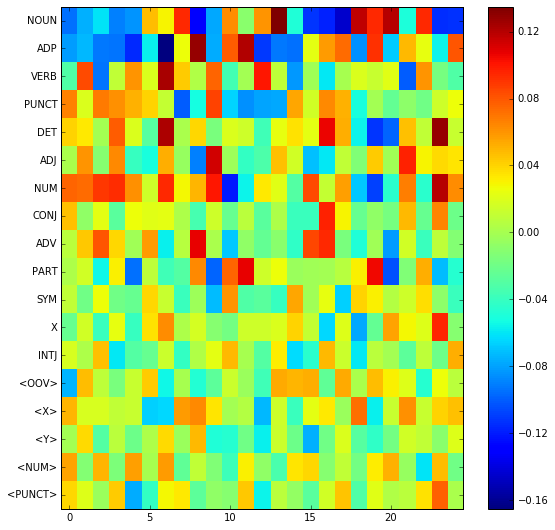

In [194]:
embeds = drnn._pos_embeddings.eval()
fig, ax = plt.subplots(1,1, figsize=(9,9))
im = ax.imshow(embeds, aspect='auto', interpolation='nearest')
plt.colorbar(im)
ax.set_yticklabels(DH._pos_vocab)
ax.set_yticks(range(len(DH._pos_vocab)))

In [101]:
# embeds = drnn._left_target_embeddings.eval()
# fig, ax = plt.subplots(1,1, figsize=(9,9))
# im = ax.imshow(embeds, aspect='auto', interpolation='nearest')
# plt.colorbar(im)

In [102]:
# embeds = drnn._right_target_embeddings.eval()
# fig, ax = plt.subplots(1,1, figsize=(9,9))
# im = ax.imshow(embeds, aspect='auto', interpolation='nearest')
# plt.colorbar(im)

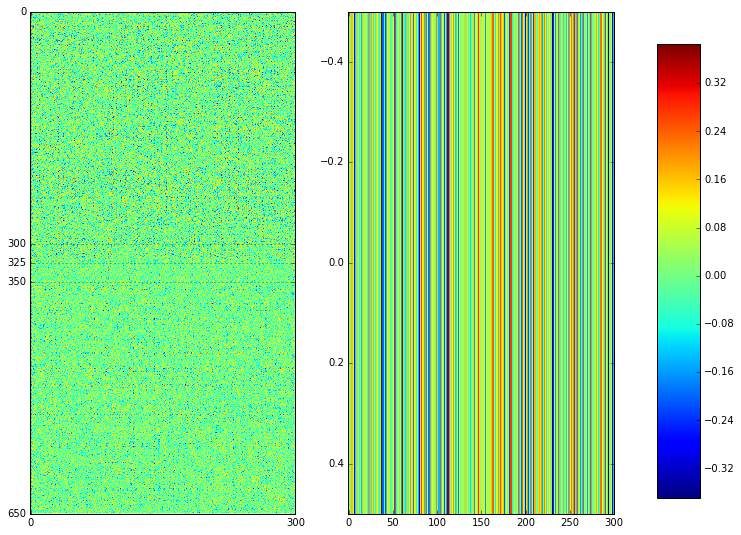

In [193]:
embeds = drnn._cand_matrix.eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')

embeds = drnn._cand_bias.eval().reshape([1,-1])
ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
ax0.set_yticks([0,300,325,350,650])
ax0.set_xticks([0, 300])
ax0.grid()
### Top half is input, bottom is r*candidate

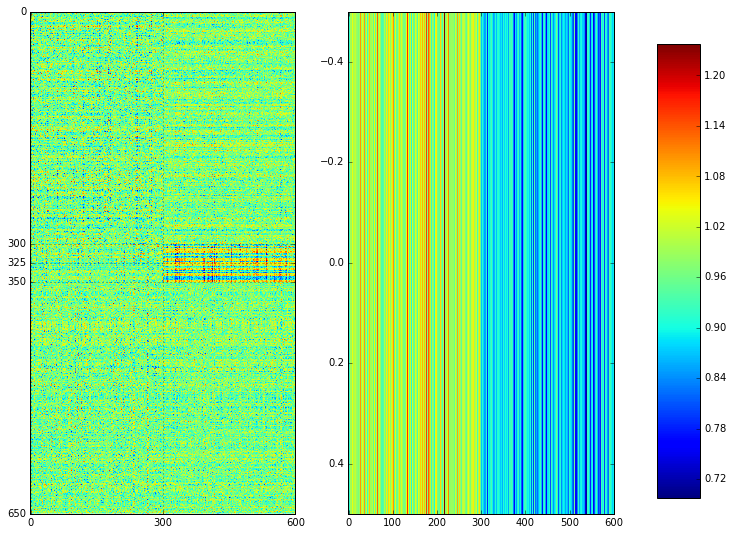

In [192]:
embeds = drnn._gate_matrix.eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')

embeds = drnn._gate_bias.eval().reshape([1,-1])
im = ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
ax0.set_yticks([0,300,325,350,650])
ax0.set_xticks([0, 300, 600])
ax0.grid()
# Left is r, right is z

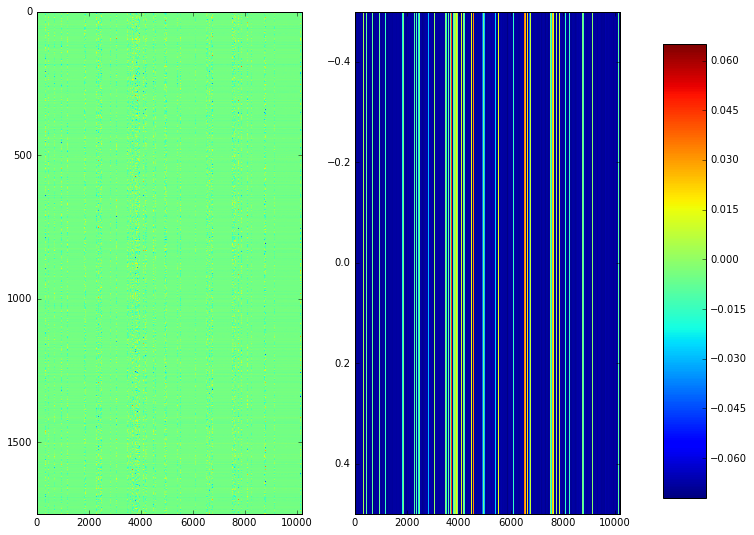

In [213]:
embeds = drnn._clusters_w.eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')

embeds = drnn._clusters_b.eval().reshape([1,-1])
im = ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

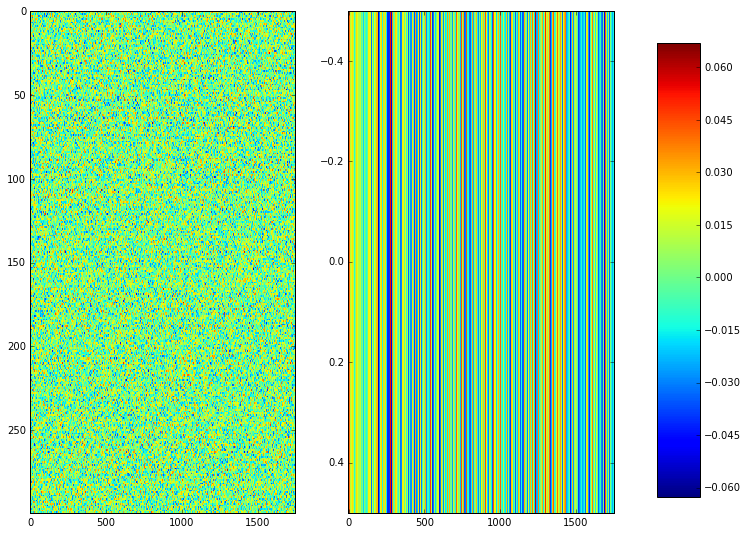

In [215]:

embeds = drnn._c_hidden_w.eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')

embeds = drnn._c_hidden_b.eval().reshape([1,-1])
im = ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [150]:
# write out predictions for test set
test_batch = DH.classification_batch(len(test['targets']), test['sdps'], test['targets'], 
                                     np.zeros(len(test['targets'])), shuffle=False)
preds = drnn.predict(test_batch[0], test_batch[1], test_batch[3])
with open('SemEval2010_task8_all_data/test_pred.txt', 'w') as f:
    i = 8001
    for pred in preds:
        f.write("%i\t%s\n" % (i, int2label[pred]))
        i += 1

In [151]:
%%bash
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl \
SemEval2010_task8_all_data/test_pred.txt SemEval2010_task8_all_data/test_keys.txt

<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 |   0    0   35   18    0    0    0    4    0    0   51    5    0    0   21    0    0    0    0 |  134    0  134
 C-E2 |   0    0   66   23    0    0    0    3    0    0   48   20    0    0   34    0    0    0    0 |  194    0  194
 C-W1 |   1    0  113   11    0    0    1    4    0    0   17    4    0    0   11    0    0    0    0 |  162    0  162
 C-W2 |   4    0   81    5    0    1    0   16    0    0   15    0    1    0   25    2    0    0    0 |  150    0  150
 C-C1 |   0    1   77   32    0    0    0    3    0    0   32    1    0    0    7    0    0    0    0 |  153    0  153
 C-C2 |   0    0   15    0    0    0    0    3    0    0    3    0    0    0   17    0   

In [23]:
def confusion_matrix(preds, labels, label_set):
    size = len(label_set)
    matrix = np.zeros([size, size]) # rows are predictions, columns are truths
    # fill in matrix
    for p, l in zip(preds, labels):
        matrix[p,l] += 1
    # compute class specific scores
    class_precision = np.zeros(size)
    class_recall = np.zeros(size)
    for label in range(size):
        tp = matrix[label, label]
        fp = np.sum(matrix[label, :]) - tp
        fn = np.sum(matrix[:, label]) - tp
        class_precision[label] = tp/float(tp + fp) if tp or fp else 0
        class_recall[label] = tp/float(tp + fn) if tp or fn else 0
    micro_f1 = np.array([2*(p*r)/(p+r) if p or r else 0 for (p, r) in zip(class_precision, class_recall)])
    avg_precision = np.mean(class_precision)
    avg_recall = np.mean(class_recall)
    macro_f1 = (2*avg_precision*avg_recall) / (avg_precision + avg_recall) if avg_precision and avg_recall else 0
    stats = {'micro_precision':class_precision*100,
             'micro_recall':class_recall*100, 
             'micro_f1':micro_f1*100,
             'macro_precision':avg_precision*100, 
             'macro_recall':avg_recall*100,
             'macro_f1':macro_f1*100}
    return matrix, stats

In [153]:
zip_train = zip(train['raws'], train['sents'], train['sdps'], train['targets'], train['labels'])
zip_valid = zip(valid['raws'], valid['sents'], valid['sdps'], valid['targets'], valid['labels'])
zip_test = zip(test['raws'], test['sents'], test['sdps'], test['targets'])

In [155]:
batch_size = 50
num_steps = len(train['labels']) // batch_size
num_epochs = 20
display_mod = 10
valid_mod = 50
best_valid = 10e6
early_stop_model = None
start = time()
for epoch in range(num_epochs):
    random.shuffle(zip_train) # shuffling should only happen once per epoch
    _, _, sdps, targets, labels = zip(*zip_train)
    for step in range(num_steps): # num_steps
        class_batch = DH.classification_batch(batch_size, sdps, targets, labels, 
                                              offset=step, shuffle=False)
        xent = drnn.partial_class_fit(*class_batch)
        if step % display_mod == 0:   
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("(%i:%i:%i) s %i/%i, e %i avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, xent))
        if step % valid_mod == 0:
            valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
            valid_xent = drnn.validation_class_loss(*valid_batch)
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("="*80)
            print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, valid_xent))
            print("="*80)
            model_file = drnn.checkpoint()
            if valid_xent < best_valid:
                print("New best validation")
                best_valid = valid_xent
                early_stop_model = model_file
    valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
    label_set = set(train['labels'])
    preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])
    cm, stats = confusion_matrix(preds, valid['labels'], label_set)
    print("Macro F1: %2.4f" % stats['macro_f1'])
# do a final validation
valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
valid_xent = drnn.validation_class_loss(*valid_batch)
m,s = divmod(time()-start, 60)
h,m = divmod(m, 60)
print("="*80)
print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, valid_xent))
print("="*80)


model_file = drnn.checkpoint()
if valid_xent < best_valid:
    best_valid = valid_xent
    early_stop_model = model_file

# now take the best of all
print("best model was %s" % early_stop_model)
# drnn.restore(early_stop_model)

(0:0:0) s 0/143, e 0 avg class xent loss = 4.1791
(0:0:0) s 0/143, e 0 validation avg class xent loss = 3.2697
Saving model to file: checkpoints/wikicluster_state.ckpt-822-2
New best validation
(0:0:8) s 10/143, e 0 avg class xent loss = 3.0487
(0:0:11) s 20/143, e 0 avg class xent loss = 3.0868
(0:0:14) s 30/143, e 0 avg class xent loss = 2.7660
(0:0:17) s 40/143, e 0 avg class xent loss = 3.0443
(0:0:20) s 50/143, e 0 avg class xent loss = 2.4351
(0:0:20) s 50/143, e 0 validation avg class xent loss = 2.4078
Saving model to file: checkpoints/wikicluster_state.ckpt-822-52
New best validation
(0:0:27) s 60/143, e 0 avg class xent loss = 2.6495
(0:0:30) s 70/143, e 0 avg class xent loss = 2.5195
(0:0:33) s 80/143, e 0 avg class xent loss = 2.5272
(0:0:37) s 90/143, e 0 avg class xent loss = 2.4137
(0:0:40) s 100/143, e 0 avg class xent loss = 2.4014
(0:0:40) s 100/143, e 0 validation avg class xent loss = 2.1106
Saving model to file: checkpoints/wikicluster_state.ckpt-822-102
New best v

New best validation
(0:3:17) s 10/143, e 3 avg class xent loss = 0.7496
(0:3:20) s 20/143, e 3 avg class xent loss = 0.7359
(0:3:24) s 30/143, e 3 avg class xent loss = 0.8935
(0:3:27) s 40/143, e 3 avg class xent loss = 0.7645
(0:3:30) s 50/143, e 3 avg class xent loss = 0.8255
(0:3:30) s 50/143, e 3 validation avg class xent loss = 0.9614
Saving model to file: checkpoints/wikicluster_state.ckpt-822-481
New best validation
(0:3:41) s 60/143, e 3 avg class xent loss = 0.5358
(0:3:44) s 70/143, e 3 avg class xent loss = 0.8614
(0:3:47) s 80/143, e 3 avg class xent loss = 0.9566
(0:3:49) s 90/143, e 3 avg class xent loss = 1.0465
(0:3:52) s 100/143, e 3 avg class xent loss = 0.8057
(0:3:52) s 100/143, e 3 validation avg class xent loss = 0.9446
Saving model to file: checkpoints/wikicluster_state.ckpt-822-531
New best validation
(0:3:58) s 110/143, e 3 avg class xent loss = 0.8913
(0:4:1) s 120/143, e 3 avg class xent loss = 0.9407
(0:4:3) s 130/143, e 3 avg class xent loss = 0.8637
(0:4:

KeyboardInterrupt: 

In [ ]:
drnn.restore(early_stop_model)

In [156]:
# write out predictions for test set
test_batch = DH.classification_batch(len(test['targets']), test['sdps'], test['targets'], 
                                     np.zeros(len(test['targets'])), shuffle=False)
preds = drnn.predict(test_batch[0], test_batch[1], test_batch[3])
with open('SemEval2010_task8_all_data/test_pred.txt', 'w') as f:
    i = 8001
    for pred in preds:
        f.write("%i\t%s\n" % (i, int2label[pred]))
        i += 1

In [157]:
%%bash
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl \
SemEval2010_task8_all_data/test_pred.txt SemEval2010_task8_all_data/test_keys.txt

<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 | 120    3    0    1    0    0    0    0    0    0    1    0    0    0    3    0    0    1    5 |  134    0  134
 C-E2 |   1  177    0    1    0    0    0    0    3    0    0    0    0    0    0    0    2    0   10 |  194    0  194
 C-W1 |   0    0  131    3    2    1    2    0    0    0    0    0    3    5    1    2    0    0   12 |  162    0  162
 C-W2 |   0    0    3  117    1    1    1    0    1    1    0    4    0    3    5    0    0    3   10 |  150    0  150
 C-C1 |   0    0    5    2  126    0   13    0    2    0    0    0    0    0    0    0    0    0    5 |  153    0  153
 C-C2 |   0    0    1    4    1   29    0    0    0    1    0    0    0    0    0    0   

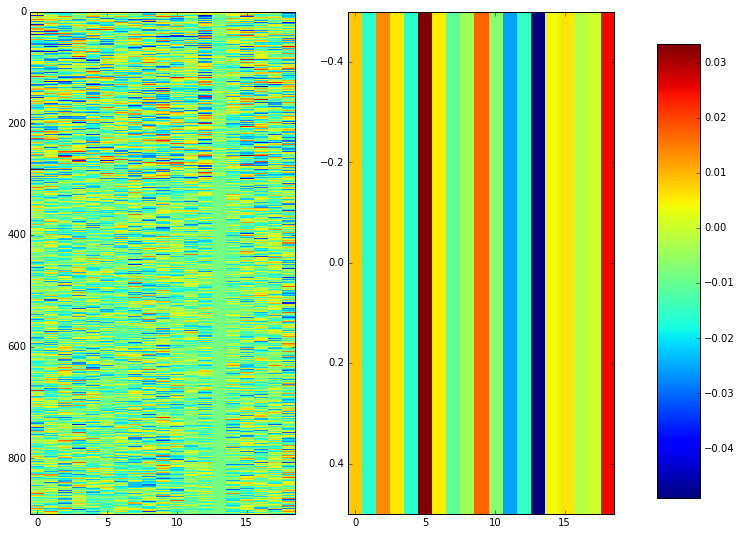

In [226]:
embeds = drnn._score_w.eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')

embeds = drnn._score_bias.eval().reshape([1,-1])
im = ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# ax0.set_yticks([0,300,600,900])
# ax0.set_xticks([])
# ax0.grid()

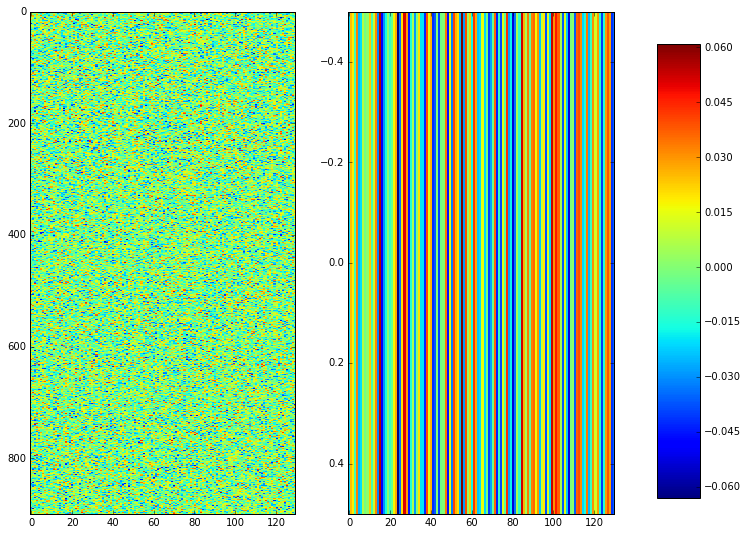

In [212]:
embeds = drnn._hidden_w.eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')

embeds = drnn._hidden_b.eval().reshape([1,-1])
im = ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [21]:
zip_train = zip(train['raws'], train['sents'], train['sdps'], train['targets'], train['labels'])
zip_valid = zip(valid['raws'], valid['sents'], valid['sdps'], valid['targets'], valid['labels'])
zip_test = zip(test['raws'], test['sents'], test['sdps'], test['targets'])

small_zip_train = zip_train[:1000]

# Multitask experiment

In [28]:
# reload(nn)
# drnn = reset_drnn(model_name='wikicluster_big', bi=False, word_embed_size=None, 
#                   num_clusters=num_clusters, max_to_keep=0)
# drnn.random_restart_score_weights()
# hyperparameters
num_epochs = 1
batch_size =250
target_neg=True
neg_per = 0
neg_level = 1
num_nearby = 25
nearby_mod = 100
sample_power = .75
DH.scale_vocab_dist(sample_power)

# bookkeeping
num_steps = DH.num_steps(batch_size)
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()

#timing stuff
start = time()
fit_time = 0
nearby_time = 0

best_valid = 100000
best_model = None

class_batch_size = 50
class_num_steps = len(zip_train) // class_batch_size #143
# class_num_steps = 50 # only look at about 1/3 of the data
num_class_epochs = 1
display_mod = 10
valid_mod = 200
best_valid = 10e6
early_stop_model = None

task_mod = 100

# random restart early stopping
last_valid = 10e6
valid_patience = 10
patience_count = 0
best_flag = False

for epoch in range(num_epochs):
    DH.shuffle_data()
    for step , batch in enumerate(DH.batches(batch_size, target_neg=target_neg, 
                                             neg_per=neg_per, neg_level=neg_level)):
        # turn batch labels into clusters
        labels = cluster_labels(batch[1], batch[2], DH, brown_clusters, num_clusters)
#             c1 = brown_clusters
        t0 = time()
        loss = drnn.partial_unsup_fit(batch[0], batch[1], labels, batch[3])
        fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
        if step % 10 == 0:
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            pps = batch_size*(neg_per + 1) / fit_time 
            print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec" 
                  % (h,m,s, step, num_steps, epoch, loss, pps))
        # run a validation test
        if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
            t0 = time()
            run_validation_test(num_nearby) # check out the nearby phrases in the validation set
            valid_batch = DH.validation_batch()
            valid_labels = cluster_labels(valid_batch[1], valid_batch[2], DH, brown_clusters, num_clusters)
            valid_loss = drnn.validation_loss(valid_batch[0], valid_batch[1], valid_labels, valid_batch[3])
            print("Validation loss: %0.4f" % valid_loss)
            nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average
        total_step +=1
        
        ## every task_mod steps, do an epoch of supervised
        if (total_step-1) % task_mod == 0: 
            print("*"*80)
            print("CLASS BATCH")
            print("*"*80)
            for class_epoch in range(num_class_epochs):
                random.shuffle(zip_train) # shuffling should only happen once per epoch
                _, _, sdps, targets, labels = zip(*zip_train)
                for class_step in range(class_num_steps): # num_steps
                    class_batch = DH.classification_batch(class_batch_size, sdps, targets, labels, 
                                                          offset=class_step, shuffle=False)
                    xent = drnn.partial_class_fit(*class_batch)
                    if class_step % display_mod == 0:   
                        m,s = divmod(time()-start, 60)
                        h,m = divmod(m, 60)
                        print("(%i:%i:%i) class s %i/%i, e %i avg class xent loss = %0.4f" % (h,m,s, class_step, class_num_steps, class_epoch, xent))
                    if class_step % valid_mod == 0:
                        valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
                        valid_xent = drnn.validation_class_loss(*valid_batch)
                        
                        # keep track of early stopping patience
                        patience_count = patience_count+1 if valid_xent > 1.1*best_valid else 0
                        if patience_count > valid_patience and best_flag:
                            print("Validation has been rising for %i consecutive checks, randomizing classification weights to avoid overfitting"
                                  % valid_patience)
                            drnn.random_restart_score_weights()
                            patience_count = 0
                            best_flag = False
                                                    
                        m,s = divmod(time()-start, 60)
                        h,m = divmod(m, 60)
                        print("="*80)
                        print("(%i:%i:%i) class s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, class_step, class_num_steps, class_epoch, valid_xent))
                        print("="*80)
                        if valid_xent < best_valid:
                            best_flag = True
                            print("New best validation")
                            best_valid = valid_xent
                            early_stop_model = drnn.checkpoint()
                valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
                label_set = set(train['labels'])
                preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])
                cm, stats = confusion_matrix(preds, valid['labels'], label_set)
                print("Macro F1: %2.4f" % stats['macro_f1'])
                
                
# do a final validation
valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
valid_xent = drnn.validation_class_loss(*valid_batch)
m,s = divmod(time()-start, 60)
h,m = divmod(m, 60)
print("="*80)
print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, valid_xent))
print("="*80)

model_file = drnn.checkpoint()
if valid_xent < best_valid:
    best_valid = valid_xent
    early_stop_model = model_file

# now take the best of all
print("best model was %s" % early_stop_model)
# drnn.restore(early_stop_model)

drnn.checkpoint()
print("Best model was %s" % best_model)

(0:0:1) step 0/3137, epoch 0 Training Loss = 0.40577 :: 807.681 phrases/sec
Top 25 closest phrases to <burmese> 'burmese succeeded became state' <state>
0: 1.000 : <burmese> 'burmese succeeded became state' <state>
1: 0.847 : <hey> 'hey conducts on basis' <basis>
2: 0.702 : <tripura> 'tripura became attained status of state' <state>
3: 0.693 : <visits> 'visits report at centre' <centre>
4: 0.683 : <mainland> 'mainland on point is fall within limits' <limits>
5: 0.638 : <see> 'see came to end' <end>
6: 0.625 : <manuel> 'manuel was imprisoned king' <king>
7: 0.621 : <portugal> 'portugal of aim in ocean' <ocean>
8: 0.615 : <seville> 'seville remained isolated from world' <world>
9: 0.612 : <one> '<NUM> as god' <god>
10: 0.601 : <behalf> 'behalf on <OOV> gave to merger' <merger>
11: 0.601 : <hey> 'hey conducts ranging from observation' <observation>
12: 0.596 : <wilson> 'wilson stated had capacity' <capacity>
13: 0.595 : <chelsea> 'chelsea kept since surrender of kingdom' <kingdom>
14: 0.5

In [26]:
# write out predictions for test set
# drnn.restore(early_stop_model)
# drnn.restore('checkpoints/wikicluster_multi.ckpt-399-530')
test_batch = DH.classification_batch(len(test['targets']), test['sdps'], test['targets'], 
                                     np.zeros(len(test['targets'])), shuffle=False)
preds = drnn.predict(test_batch[0], test_batch[1], test_batch[3])
with open('SemEval2010_task8_all_data/test_pred.txt', 'w') as f:
    i = 8001
    for pred in preds:
        f.write("%i\t%s\n" % (i, int2label[pred]))
        i += 1

In [27]:
%%bash
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl \
SemEval2010_task8_all_data/test_pred.txt SemEval2010_task8_all_data/test_keys.txt

<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 | 116    2    1    0    0    0    0    0    0    0    0    0    0    0    0    1    0    1   13 |  134    0  134
 C-E2 |   3  166    0    0    0    0    0    0    1    1    0    0    0    0    0    1    3    1   18 |  194    0  194
 C-W1 |   0    1  119    3    3    0    0    0    2    1    1    1    2    6    2    0    0    0   21 |  162    0  162
 C-W2 |   0    0    4   96    1    0    1    0    1    0    2    5    0    5    4    0    0    3   28 |  150    0  150
 C-C1 |   0    0    4    0  120    2    9    0    0    1    0    0    1    0    0    1    1    0   14 |  153    0  153
 C-C2 |   0    0    0    2    1   29    0    0    0    1    0    0    0    0    1    0   